In [8]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

du = {
0.2:[0.320878628692,0.014354985748],
0.4:[0.28759238955,0.0173941871764],
0.8:[0.179652184681,0.012733736384],
1.2:[0.152164204092,0.0106738755021],
1.6:[0.144804252876,0.00974592070867],
2.0:[0.142805206381,0.0110827643436],
}


def get_Rij(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    d = {}
    d['R11'] = dat[:,0]
    d['R12'] = dat[:,1]
    d['R22'] = dat[:,3]  
    d['R33'] = dat[:,5]  
    return d#R11,R12,R22

directory = '/home/kmatsuno/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"shearlayer_Rij*")
flist.sort()
print([f.split('/')[-1] for f in flist])

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 0.2
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['shearlayer_Rij_0001.dat', 'shearlayer_Rij_0003.dat', 'shearlayer_Rij_0004.dat', 'shearlayer_Rij_0005.dat', 'shearlayer_Rij_0012.dat', 'shearlayer_Rij_0013.dat', 'shearlayer_Rij_0014.dat', 'shearlayer_Rij_0015.dat', 'shearlayer_Rij_0016.dat', 'shearlayer_Rij_0017.dat', 'shearlayer_Rij_0018.dat', 'shearlayer_Rij_0019.dat', 'shearlayer_Rij_0020.dat', 'shearlayer_Rij_0101.dat', 'shearlayer_Rij_0102.dat', 'shearlayer_Rij_0103.dat', 'shearlayer_Rij_0104.dat', 'shearlayer_Rij_0105.dat', 'shearlayer_Rij_0106.dat', 'shearlayer_Rij_0107.dat', 'shearlayer_Rij_0108.dat', 'shearlayer_Rij_0109.dat', 'shearlayer_Rij_0110.dat', 'shearlayer_Rij_0111.dat', 'shearlayer_Rij_0112.dat', 'shearlayer_Rij_0113.dat']


0.2: [0.10194116141,0.000581312907797],
0.4: [0.177871665129,0.0],
0.8: [0.322907230378,0.001969494767],
1.2: [0.422170359955,0.000365143329778],
1.6: [0.470494387813,0.0121378996277],
2.0: [0.483597628328,0.00671161702576],
}


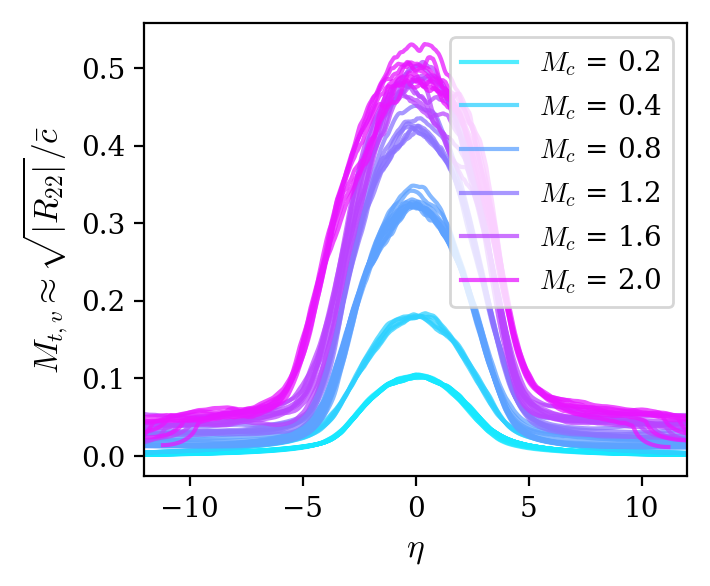

In [9]:
s = '1'
# Mc_list = ['02','08','20']
Mc_list = ['02','04','08','12','16','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)

for k in range(1):
    fig = plt.figure(figsize=(3.5,3),dpi=200)
    for i,Mc in enumerate(Mc_list):
        directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
        filename_prefix = directory + '/shearlayer_'
        inp = nml.inputs(directory)
        tlist,dlist,rates = growth_rates(directory+'shearlayer_')
        Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
        Ny = int(Ny)
        y = np.linspace(-Ly/2.,Ly/2.,Ny)
        
        flist = glob.glob(directory+"shearlayer_Rij*")
        flist.sort()

        if Mc=='02': ist=9;ien=-1
        elif Mc=='04': ist=4;ien=13-4
        elif Mc=='12': ist=4;ien=-1
        elif Mc=='20': ist=4;ien=-1
        else: ist=3; ien=None
        
        colorVal = scalarMap.to_rgba(inp.Mc)
        mat = np.zeros(len(flist[ist:ien]))
        for j,fname in enumerate(flist[ist:ien]):
            tID = fname.split('/')[-1]
            tID = tID.split('_')[-1]
            tID = int(tID.split('.')[0])
            time = nml.read_time(directory,tID)

            # Get dtheta
            idx = np.argmin(abs(tlist-time))
            dtheta = dlist[idx]
            eta = y/dtheta
            
            # Get cbar:
            cbar = np.fromfile( directory + 'shearlayer_cbar_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
        
            # Get shear stress
            d = get_Rij(fname)
            
            # Mtau
            Mt = np.sqrt(abs(d['R11'])+abs(d['R22'])+abs(d['R33']))/cbar
            #Mt = np.sqrt(abs(d['R12']))/cbar
            #scale = 1./(du[inp.Mc][0]*inp.du)
            fplot = Mt#*scale
            
            #colorVal = 'C0'
            if j==0: plt.plot(-eta,fplot,alpha=0.75,color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
            else: plt.plot(-eta,fplot,alpha=0.75,color=colorVal)
            mat[j] = fplot[Ny/2]
        print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[ist:ien]),np.std(mat[ist:ien])))
        
    plt.xlim([-12,12])
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$M_{t,v}\approx\sqrt{|R_{22}|}/\bar{c}$')
    plt.legend(fontsize=10)
    
    print('}')

0.2: [0.101194547,0.00331450550581],
0.4: [0.0943282004909,0.00242975868545],
0.8: [0.0801846132879,0.00267113312561],
1.2: [0.0716829829154,0.00365138782128],
1.6: [0.0650486825883,0.00192662215982],
2.0: [0.0571926423219,0.00246586404373],
}


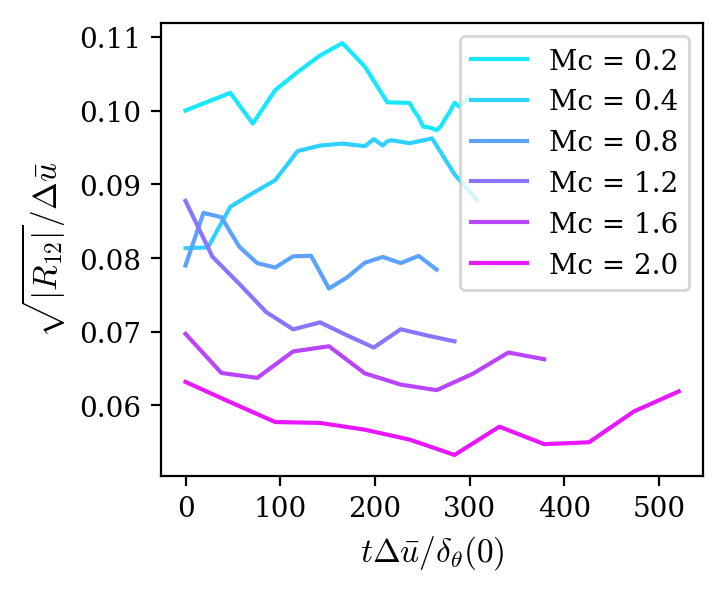

In [52]:
# plot vs time
s = '1'
# Mc_list = ['02','08','20']
Mc_list = ['02','04','08','12','16','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)

for k in range(1):
    fig = plt.figure(figsize=(3.5,3),dpi=200)
    for i,Mc in enumerate(Mc_list):
        directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
        filename_prefix = directory + '/shearlayer_'
        inp = nml.inputs(directory)
        tlist,dlist,rates = growth_rates(directory+'shearlayer_')
        Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
        Ny = int(Ny)
        y = np.linspace(-Ly/2.,Ly/2.,Ny)
        
        flist = glob.glob(directory+"shearlayer_Rij*")
        flist.sort()

        ist = 1; ien=None
        if Mc=='02': ist=3;ien=None
        elif Mc=='04': ist=4;ien=None
        #elif Mc=='12': ist=4;ien=-1
        #elif Mc=='20': ist=4;ien=-1
        #else: ist=3; ien=None
        
        colorVal = scalarMap.to_rgba(inp.Mc)
        mat = np.zeros([2,len(flist[ist:ien])])
        for j,fname in enumerate(flist[ist:ien]):
            tID = fname.split('/')[-1]
            tID = tID.split('_')[-1]
            tID = int(tID.split('.')[0])
            time = nml.read_time(directory,tID)

            # Get dtheta
            idx = np.argmin(abs(tlist-time))
            dtheta = dlist[idx]
            eta = y/dtheta
            
            # Get cbar:
            cbar = np.fromfile( directory + 'shearlayer_cbar_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
        
            # Get shear stress
            d = get_Rij(fname)
            
            Mt = np.sqrt(abs(d['R11'])+abs(d['R22'])+abs(d['R33']))/cbar
            #Mtv = np.sqrt(abs(d['R22']))/cbar
            Mtau = np.sqrt(abs(d['R12']))/cbar
            #scale = 1./(du[inp.Mc][0]*inp.du)
            fplot = np.sqrt(abs(d['R12']))/inp.du;
            mat[0,j] = time*inp.du
            mat[1,j] = np.amax(abs(fplot))#[Ny/2]
        
        isort = np.argsort(mat[0,:])
        mat[0,:] = mat[0,isort]
        mat[1,:] = mat[1,isort]
        #colorVal = 'C0'
        plt.plot(mat[0,:]-mat[0,0],mat[1,:],alpha=1.0,color=colorVal,label='Mc = {}'.format(inp.Mc))
        print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[1,ist:ien]),np.std(mat[1,ist:ien])))
        
#     plt.xlim([-12,12])
    plt.xlabel(r'$t\Delta\bar{u}/\delta_\theta(0)$')
    plt.ylabel(r'$\sqrt{|R_{12}|}/\Delta\bar{u}$')
    plt.legend(fontsize=10)
    
    print('}')

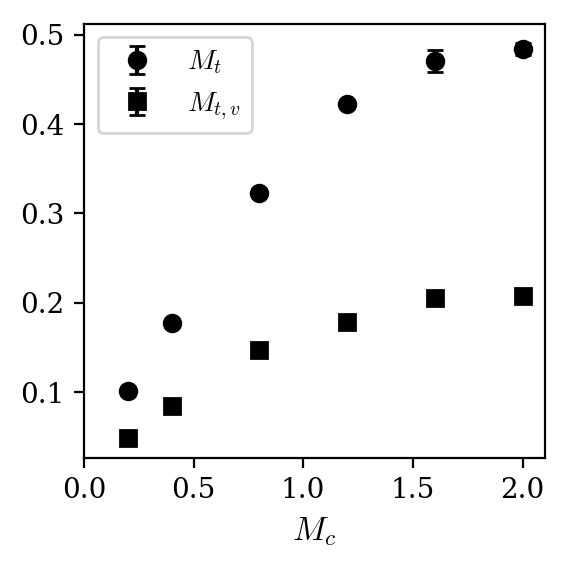

In [10]:
Mtv = {
0.2: [0.0490960614614,0.000213792497384],
0.4: [0.0851298172131,0.0],
0.8: [0.147221788636,0.00194793675448],
1.2: [0.178986119918,0.0021200206684],
1.6: [0.205616805632,0.00688617276981],
2.0: [0.208086519107,0.00429828742598],
}
Mt = {
0.2: [0.10194116141,0.000581312907797],
0.4: [0.177871665129,0.0],
0.8: [0.322907230378,0.001969494767],
1.2: [0.422170359955,0.000365143329778],
1.6: [0.470494387813,0.0121378996277],
2.0: [0.483597628328,0.00671161702576],
}

def plotter(dat,fmt,label):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()],
        yerr=[x[1] for x in dat.values()],fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(3,3),dpi=200)
plotter(Mt,'ko','$M_t$')
plotter(Mtv,'ks','$M_{t,v}$')

plt.xlabel(r'$M_c$')
# plt.ylabel(r'$M_{t,v}\approx\sqrt{|R_{22}|}/\bar{c}$')
plt.legend(fontsize=10)
plt.xlim([0,2.1])
plt.tight_layout()
# plt.savefig('/home/kmatsuno/ShearLayer_img/Rij.png',dpi=200, bbox_inches='tight')